# Interpret the results obtained from each of the experiments

The results from the experiments involve interpreting and plotting several quantities
- CPU Utilization of the slaves during the experiments
- IO Wait of the slaves during the experiments
- Accuracy of the final model after 10 epochs
- Response time of the model after 10 epochs

(Possible other result to see)
- Throughput of the model

In [49]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from collections import defaultdict
import glob
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols


C:\Users\diego\AppData\Local\Programs\Python\Python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Extract from the log files the Accuracy and the Response Time

The files are in the folder from the master server, and we get a final line in the files with
the total wall clock time and the final accuracy

The folder structure taken into consideration is the following, from the root folder for the set
of experiments in question (2k or full) we get 4 folders, 1 for the master and 1 for each slave,
and inside these folders we get 1 folder for each of the replications. Inside we should find the
pickle files and the log files in case of the master


In [2]:
from typing import List, Dict


# Create some class to comfortably save the experiments and their results
class Experiment:
    def __init__(self, name: str):
        """Given the name of the experiment, extract the number of cpu's
        and so on"""
        self._name = name

        # Extract the cpu, batch and njobs by splitting
        parts = name.split('-')
        self.cpu = int(parts[0].replace('cpu', '').strip())
        self.batch = int(parts[1].replace('batch', '').strip())
        self.njobs = int(parts[2].replace('njobs', '').strip())

    # Override the hash function so we can use it as
    # key of the dictionary
    def __hash__(self):
        return self._name

class ExperimentResults:

    def __init__(self, time: float, accuracies: List[float]):
        self.time = time
        self.accuracies = accuracies
        self.final_accuracy = accuracies[-1]


In [3]:

def split_name(exp_name: str) -> (int, int, int):
    """Given the name of the file give back the settings of the experiment"""
    parts = exp_name.split('-')
    cpu = int(parts[0].replace('cpu', '').strip())
    batch = int(parts[1].replace('batch', '').strip())
    njobs = int(parts[2].replace('njobs', '').strip())

    return cpu, batch, njobs

# Read the folder os the master and search for the accuracy to build the dictionary
# Right now for testing it just has one replication

# This is the path we should change to either analyze the 2k or the full factorial
path_root_master = './experiments/fullfact/master/'

# get the log files
logs = glob.glob(os.path.join(path_root_master, '*.log'))

# Get a dict ready to transform into a dataframe for training of the
# model and representation
results = {
    'exp_name': [],
    'cpu': [],
    'batch': [],
    'njobs': [],
    'time': [],
    'accuracies':[],
    'final accuracy': []
}
# Just take the final valuie for the ANOVA test
# res_final = defaultdict(dict)



print(f'Extracting the data from {len(logs)} files')
for log in logs:
    acc = []
    with open(log, 'r') as f:
        for line in f:
            if 'Top1Accuracy is Accuracy' in line:
                try:
                    _accuracy = line.strip().split(']')[-1].split(',')[-1].split(':')[-1].replace(')', '')
                    acc.append(float(_accuracy.strip()))
                except Exception as e:
                    print('Error while reading accuracy',e)
                if len(acc) == 10:
                    # Then save the time here
                    time = float(line.strip().split(']')[-2].split('[')[-1].split(' ')[-1].replace('s', ''))
                    break
    # Add the results to the dictionary
    variables = log.split('-')[1:]
    name = '-'.join(variables).replace('.log', '')
    cpu, batch, njobs = split_name(name)
    # set all the columns
    results['cpu'].append(cpu)
    results['batch'].append(batch)
    results['njobs'].append(njobs)
    results['accuracies'].append(acc)
    results['time'].append(time)
    results['final accuracy'].append(acc[-1])
    results['exp_name'].append(name)

    # # Fill in the anova dictionary too
    # res_final[name]['time'] = time
    # res_final[name]['accuracy'] = acc[-1]

results_df = pd.DataFrame(results)
results_df = results_df.set_index('exp_name')

# We should get the last accuracy to run ANOVA but to plot this is better
results_df

Extracting the data from 48 files
Error while reading accuracy could not convert string to float: 'validate model throughput is 23402.63 records/second'


,cpu,batch,njobs,time,accuracies,final accuracy
exp_name,,,,,,
cpu1-batch64-njobs1,1,64,1,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567
cpu2-batch64-njobs1,2,64,1,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580
cpu4-batch256-njobs1,4,256,1,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288
cpu8-batch256-njobs1,8,256,1,153.905961,"[0.6872, 0.7999, 0.8486, 0.8739, 0.8889, 0.9, ...",0.9213
cpu1-batch512-njobs1,1,512,1,179.730715,"[0.5992, 0.7516, 0.7949, 0.8287, 0.8485, 0.864...",0.8957
cpu2-batch512-njobs1,2,512,1,121.816806,"[0.6058, 0.7224, 0.787, 0.8286, 0.8513, 0.866,...",0.8981
cpu4-batch512-njobs1,4,512,1,93.370698,"[0.5386, 0.6622, 0.7399, 0.7904, 0.8218, 0.842...",0.8834
cpu8-batch512-njobs1,8,512,1,86.659146,"[0.5001, 0.6607, 0.7281, 0.7863, 0.8248, 0.850...",0.8920
cpu1-batch64-njobs3,1,64,3,512.443133,"[0.8865, 0.9221, 0.9368, 0.9446, 0.9502, 0.954...",0.9653


In [ ]:
results_df.loc['cpu8-batch512-njobs5', 'time']

# Extract the CPU and IO wait from the pickle files

In this case we need the slave folders (we will check that the folder contains the word slave to analyze the files)
and we will extract the pickle files from where we will get the CPU load and the IO wait percentage

There is a thing to take in mind. The experiment runs for a default of 5 minutes, so if the experiment lasted
less than 300 seconds, which we can get from the results dictionary from before, we should trim the vectors taking
into account that each measurement is taken every 2 seconds so it just comprises that experiment and doesn't
introduce noise from the next

In [4]:
def coalesce_metrics(loads, threshold = 1):
    """We have three slaves, and sometimes not all of them are working
    if the numnber of cpus and jobs is just one

    In these cases,  discard the lists with an average too close to zero,
    if not, add the slaves together and calculate the mean at each point to
    get the final vector."

    :param: threshold: the threshold of utilization under which we conside
                        that the server was not used in the experiment"""

    avg_loads = {}
    for exp, slaves in loads.items():
        print(f'\n{exp}')
        count = 0
        for slave, metrics in slaves.items():
            c = np.zeros(len(metrics['cpu']))
            io = np.zeros(len(metrics['iowait']))
            # if the mean is too slow discard
            cpu_mean = np.mean(metrics['cpu'])
            if  cpu_mean <threshold:
                print(f'Discarding {slave} with cpu mean =',cpu_mean)
            else:

                c += metrics['cpu']
                io += metrics['iowait']
                count += 1
                # print(slave, np.mean(metrics['cpu']), np.mean(metrics['iowait']))
                # print(metrics['cpu'])

        # print('dividing by ',count)
        avg_loads[exp] = {
            'cpu': c / count,
            'iowait': io/count
        }

    return avg_loads

In [5]:
root_folder_slaves = './experiments/fullfact/'

dirs = os.listdir(root_folder_slaves)
slave_dirs = [f for f in dirs if 'slave' in f]


loads = defaultdict(dict)
# The shape of the results is
# name of the file:
#     - slave 1:
#         - cpu: list
#         - iowait: list
#     - slave 2:
#         ...

# Do the same in all the folders
for folder in slave_dirs:
    print('Processing files for the', folder)
    # get just the pickle files
    files = glob.glob(os.path.join(root_folder_slaves, folder, '*.pkl'))

    # Extract the dictionary from each file
    for f in files:

        # Get the name of the experiment to index the other dict
        variables = f.split('-')[1:]
        exp_name = '-'.join(variables).replace('.pkl', '')
        # print(exp_name)

        with open(f, 'rb') as pickle_file:
            metrics = pickle.load(pickle_file)

        # Now we need to check to just get the metrics concerning the experiment
        # And not the following. We leave a margin of 10 seconds or 5 list positions just in case
        # to not cut too tightly
        exp_length = results_df.loc[exp_name, 'time']
        if exp_length > 300:
             loads[exp_name][folder] = metrics
        else:
            max_list_length = math.ceil(exp_length/2) + 5
            print(f'Exp length was {exp_length}, so max list positions are {max_list_length}')
            if max_list_length < len(metrics['cpu']):
                loads[exp_name][folder] = dict()
                loads[exp_name][folder]['cpu'] = metrics['cpu'][:max_list_length]
                loads[exp_name][folder]['iowait'] = metrics['iowait'][:max_list_length]
                continue

# Get the average usage of the experiments
# The resulting dict will just map each
# pf the experiments to its avg cpu load and
# iowait across all slaves
avg_loads = coalesce_metrics(loads)




Processing files for the slave1
Exp length was 153.519245625, so max list positions are 82
Exp length was 153.905961347, so max list positions are 82
Exp length was 179.730714818, so max list positions are 95
Exp length was 121.816806401, so max list positions are 66
Exp length was 93.370698303, so max list positions are 52
Exp length was 86.659146109, so max list positions are 49
Exp length was 298.232984557, so max list positions are 155
Exp length was 292.36674628, so max list positions are 152
Exp length was 226.514271834, so max list positions are 119
Exp length was 187.450313053, so max list positions are 99
Exp length was 172.501354772, so max list positions are 92
Exp length was 200.989036153, so max list positions are 106
Exp length was 180.681545942, so max list positions are 96
Exp length was 133.421901098, so max list positions are 72
Exp length was 105.814118644, so max list positions are 58
Exp length was 105.814118644, so max list positions are 58
Exp length was 270.8785

## Plot the loads for each of the slaves for each of the experiments

In some experiments some of the slaves have zero load cause they are not used, in those cases
we should filter out the lists whose average is too close to zero. In other cases, we can just average the
load among all of the slaves.

#### See the relationship with time

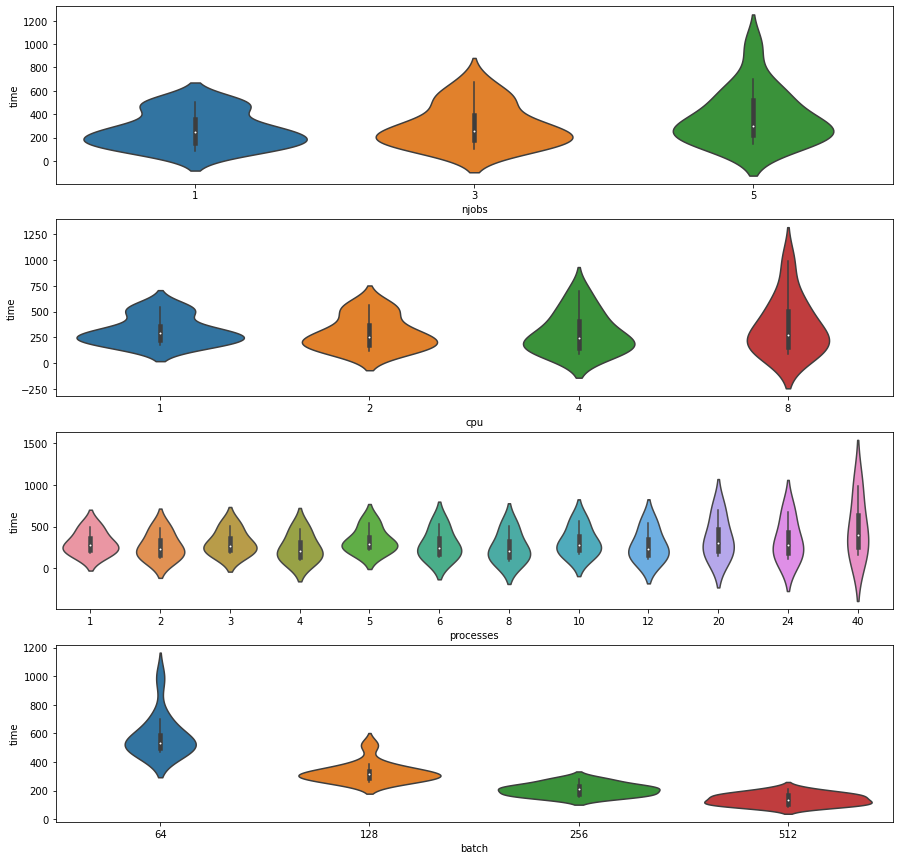

In [84]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='time', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='time', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.violinplot(x='processes', y='time', data=results_df, ax=ax3)
sns.violinplot(x='batch', y='time', data=results_df, ax=ax4);


#### See the relationships with the accuracy


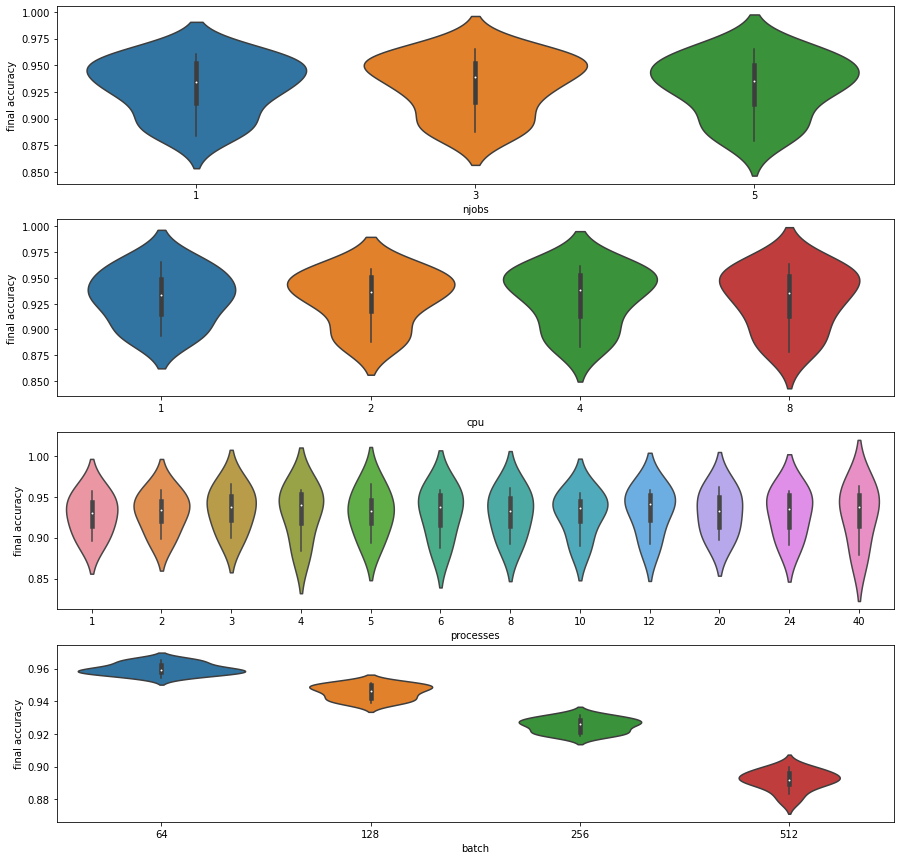

In [85]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='final accuracy', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='final accuracy', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.violinplot(x='processes', y='final accuracy', data=results_df, ax=ax3)
sns.violinplot(x='batch', y='final accuracy', data=results_df, ax=ax4);

In [ ]:
# Functions to plot results



# TODO finish this
def plot_accuracies(df: pd.DataFrame,  final_value=False, by = None):
    """Plot the accuracies as a time series using 'by' as the X axis"""

    if not final_value:
        # Get the max time of the experiments to set as x axis
        max_time = df['time'].max()

        for exp, row in df.iterrows():
            times = np.linspace(0, row.time, 10)
            plt.plot(times, row.accuracies, label=exp)

        plt.legend()
        plt.show()

    else:

        if by is not None:
            _df = df.groupby(by)['final accuracy'].mean()
            if isinstance(by, list):
                names = _df.index.names
                x = [f'{names[0]}-{names[1]}']

            plt.bar(_df.index, _df.values)
            plt.show()
        else:
            # use the names as x-axis and the accuracy as the y
            plt.bar(df.index,df['final accuracy'])
            plt.show()




### Regress the datapoints we have to get an idea of the performance

In [44]:
# We want to fit the response time based on the number of processes (cpu * jobs) and the batch size

# 1) Transform the dataset
df_regr = results_df[['cpu', 'batch', 'njobs', 'time', 'final accuracy']]
df_regr['processes'] = df_regr['cpu'] * df_regr['njobs']
df_regr = df_regr[['processes', 'batch', 'time', 'final accuracy']]

X = df_regr[['processes', 'batch']].reset_index(drop=True)
# X = df_regr[['cpu','njobs', 'batch']].reset_index(drop=True)
y_time = df_regr['time'].reset_index(drop=True)
y_acc = df_regr['final accuracy'].reset_index(drop=True)

scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
# Scale the data

%matplotlib inline

scaler = StandardScaler()
xtrain = scaler.fit_transform(X)
# print(xtrain)

# PLot the datapoints
from mpl_toolkits.mplot3d import Axes3D

# plot the train examples
f = plt.figure()
ax = Axes3D(f)
print(xtrain.shape, y.ravel().shape)
ax.scatter(xtrain[:,0], xtrain[:,1], y, c='r')

# Fit a simple linear regression
regressors = [LinearRegression(), Lasso(alpha=1), Ridge(), DecisionTreeRegressor(), RandomForestRegressor()]

# Try with second order stats
x_2 = xtrain**2
xtrain_2 = np.concatenate((xtrain, xtrain**2, xtrain**3), axis =1)
# print(xtrain_2)

for r in regressors:
    loo = LeaveOneOut()

    scores = cross_validate(r, xtrain, y, cv=loo, scoring='neg_mean_squared_error')

    print(r,scores)


x1,x2 = np.meshgrid(np.linspace(-2,2), np.linspace(-2,2))

lr = regressors[0].fit(xtrain, y)
inter = lr.intercept_
coefs = lr.coef_

y_out = coefs[0]*x1+coefs[1]*x2 + inter
print(inter, coefs)
ax.plot_wireframe(x1,x2,y_out);

In [45]:
# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams

from sklearn.model_selection import GridSearchCV, train_test_split

x_train, x_test, y_train_acc, y_test_acc = train_test_split(X, y_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(X, y_time, test_size=0.2, random_state = 42)

reg_acc = RandomForestRegressor(random_state=42)
reg_time = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': [50, 100, 150, 200, 500,100],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,10),
    'criterion': ['mse', 'mae']
    
}

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

Fitting the time...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 208 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 528 tasks      | elapsed:   18.4s
[Parallel(n_jobs=8)]: Done 976 tasks      | elapsed:   36.3s
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:   40.4s finished


Fitting the accuracy
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 208 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 528 tasks      | elapsed:   19.1s
[Parallel(n_jobs=8)]: Done 976 tasks      | elapsed:   36.4s
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:   41.0s finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=8,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(4, 10),
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 150, 200, 500, 100]},
             verbose=3)

In [46]:
cv_time.best_params_

{'criterion': 'mae',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 500}

In [47]:
cv_acc.best_params_

{'criterion': 'mae',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 500}

### Fit the regressors on the accuracy and time

In [48]:
from sklearn.metrics import mean_squared_error

# 1) Fit on the time
r_t = cv_time.best_estimator_.fit(x_train, y_train_time)

# test the performance on the train and the test set
y_pred = r_t.predict(x_test)

err = mean_squared_error(y_pred, y_test_time)

print('Mean Squared Error with the test set is for TIME', err)


# 2) Fit on the acc
r_acc = cv_acc.best_estimator_.fit(x_train, y_train_acc)

# test the performance on the train and the test set
y_pred = r_acc.predict(x_test)
err = mean_squared_error(y_pred, y_test_acc)

print('Mean Squared Error with the test set is for ACCURACY', err)

Mean Squared Error with the test set is for TIME 1024.8644910549706
Mean Squared Error with the test set is for ACCURACY 1.4282332284000623e-05


In [ ]:
# Run some examples with it

## Create the Final Optimizer that will multiplex the regressors seen above

In [6]:
# Import the 3 regressors
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_validate


from typing import Tuple, Optional
# Declare the class for the ML model

from dataclasses import dataclass

@dataclass
class Job:
    cpu:int
    njobs: int


class Courier:
    """ Courier has 3 parameters to account for utilization, accuracy and response time,
    based on which, and their weights, it chooses the optimal batch size for the task

    labels are in format dict
    accuracy -> labels
    time -> labels
    utilization -> labels
    """

    def __init__(self, alpha: float, beta: float, gamma: float,
                 X,
                 labels: Dict[str,Optional[np.ndarray]] , model, batches=[64,128,256,512]):


        self.batches = batches

        if alpha + beta + gamma !=1:
            raise ValueError('The hyperparameters need to add up to 1')

        # save the type of model we want to fit
        self.model = model

        # Configure the hyperparams and the training data
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.X = self._preprocess_data(X)

        # Get the labels for each of the predictors
        self.accuracy = labels['accuracy']
        self.time = labels['time']
        self.utilization = labels['utilization']

        # Compute the predictors
        self.acc_model = self._fit_model(self.accuracy)
        self.time_model = self._fit_model(self.time)
        self.util_model = self._fit_model(self.utilization)

    def optimize(self, job: Job, max_time = None):
        acc, t, util = self._predict(job)
        print(f'Accuracy:{acc}, Time:{t}, Util:{util}')



        if max_time:
            # Just take the options that satisfy the requirements
            fit = t[t<max_time]
            if len(fit) == 0:
                print('Not a single value fulfills the '
                      'time requirements, selecting minimum time')
                # Return the minimum time
                min_t_idx = np.where(t == t.min())[0][0]
                return self.batches[min_t_idx], (acc[min_t_idx],
                                                 t[min_t_idx],
                                                 util[min_t_idx])

            else:
                acc = acc[t<max_time]
                t = t[t<max_time]
                util = util[t<max_time]


        # Return the batch that better fulfills the requirements and
        # also return a tuple with the predictions
        sc_a = acc/np.max(acc)
        sc_t = 1-( t/np.max(t))
        sc_util = util/np.max(util)

        sc = self.alpha * sc_a + self.beta * sc_t + self.gamma * sc_util

        # Get the index of the max score
        max_sc_idx = np.where(sc == sc.max())[0][0]
        return  self.batches[max_sc_idx], (acc[max_sc_idx],
                                           t[max_sc_idx],
                                           util[max_sc_idx])



    def _fit_model(self, labels):
        """Fit the model to particular labels"""
        reg = self.model
        reg.fit(self.X, labels)
        return reg


    def _preprocess_data(self, X):
        """Standardizes the data"""
        scaler = StandardScaler()
        return scaler.fit_transform(X)

    def _predict(self, job: Job):
        """Predicts the time, accuracy and util with different batches
        and returns the best one given the optims"""

        acc = []
        t = []
        util = []

        # predict the performance of the job with different batches
        for b in self.batches:
            _acc = self.acc_model.predict([b, job.cpu, * job.njobs])
            _t = self.time_model.predict([b, job.cpu, * job.njobs])
            _util = self.util_model.predict([b, job.cpu, * job.njobs])

            acc.append(_acc)
            t.append(_t)
            util.append(_util)

        return np.array(acc), np.array(t), np.array(util)




C:\Users\diego\AppData\Local\Programs\Python\Python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\diego\AppData\Local\Programs\Python\Python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\diego\AppData\Local\Programs\Python\Python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\diego\AppData\Local\Programs\Python\Python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Run the ANOVA test with all of the results


In [ ]:



# Get the last accuracy instead of the list for the accuracy of each of the experiments

df = pd.DataFrame(res_final)

df